In [69]:
import json
from krxns.config import filepaths
from krxns.utils import str2int
from krxns.cheminfo import draw_reaction
from krxns.net_construction import fold_reactions, extract_compounds, handle_multiple_rules, remove_unpaired_cofactors, translate_operator_adj_mat
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import SVG

In [28]:
whitelist_fn = "top_50_whitelist.json"

# Load unpaired cofactors
with open(filepaths['coreactants'] / 'unpaired_cofactors.json', 'r') as f:
    unpaired_cofactors = json.load(f)

# Load known reaction data
with open(filepaths['data'] / 'sprhea_240310_v3_mapped.json', 'r') as f:
    known_reactions = json.load(f)

known_reactions = fold_reactions(known_reactions)
known_compounds, smi2id = extract_compounds(known_reactions)

# Load op connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_operator.json', 'r') as f:
    op_cxns = str2int(json.load(f))

# Load sim connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_similarity.json', 'r') as f:
    sim_cxn = str2int(json.load(f))

with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_side_counts.json', 'r') as f:
    side_counts = str2int(json.load(f))

# Load coreactant whitelist
with open(filepaths['coreactants'] / whitelist_fn, 'r') as f:
    coreactant_whitelist = json.load(f)


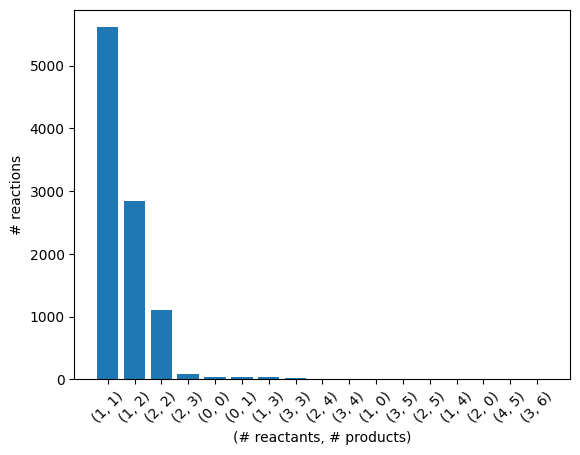

In [29]:
cts = Counter([tuple(elt) for elt in side_counts.values()])
x_labels, cts = zip(*sorted([(k, v) for k,v in cts.items()], key= lambda x : x[1], reverse=True))
x = np.arange(len(x_labels))

fig, ax = plt.subplots()
ax.bar(x, height=cts)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45)
ax.set_ylabel("# reactions")
ax.set_xlabel("(# reactants, # products)")
plt.show()

In [55]:
def sim_cxn_displayor(rid):
    translate = lambda x : {known_compounds[outer]['name']: {known_compounds[inner]['name']: inner_v  for inner, inner_v in outer_v.items()} for outer, outer_v in x.items()}
    if rid in op_cxns:
        rule = list(op_cxns[rid].keys())[0]
        rct_inlinks = op_cxns[rid][rule]['rct_inlinks']
        pdt_inlinks = op_cxns[rid][rule]['pdt_inlinks']
    else:
        print("Not operator connected")
        rct_inlinks = translate(sim_cxn[rid]['rct_inlinks'])
        pdt_inlinks = translate(sim_cxn[rid]['pdt_inlinks'])

    print("Rct inlinks")
    for k, v in rct_inlinks.items():
        print(k, v)
    print("\nPdt inlinks")
    for k, v in pdt_inlinks.items():
        print(k, v)
    display(SVG(draw_reaction(known_reactions[rid]['smarts'], sub_img_size=(300, 200))))

def show_sim_cxn(options: list):
    sim_cxn_dropdown = widgets.Dropdown(options=options, value=options[0])
    return interact(sim_cxn_displayor, rid=sim_cxn_dropdown)

In [56]:
ct_of_i = (2,2)
_ = show_sim_cxn([elt for elt in sim_cxn.keys() if tuple(side_counts[elt]) == ct_of_i])

interactive(children=(Dropdown(description='rid', options=(1123, 14312, 6566, 2415, 2716, 9293, 16344, 2235, 1…

In [44]:
tutu = [elt for elt in sim_cxn.keys() if tuple(side_counts[elt]) == (2,2)]
tutu_op = [elt for elt in tutu if elt in op_cxns]
len(tutu_op) / len(tutu)

0.661524500907441

In [88]:
# Count up number of extra nodes I'll need for multi-molecule-nodes

sel = lambda rid : rid in op_cxns and not any([elt == 0 for elt in side_counts[rid]]) and any([elt > 1 for elt in side_counts[rid]])
direction_from_side = lambda side : 0 if side == 'rct_inlinks' else 1 if side == 'pdt_inlinks' else print("Error side key not found")
ocs_of_i = {rid: op_cxns[rid] for rid in op_cxns if sel(rid)} # Get all reactions with no side ==0 and any side count > 1 and have been mapped by operator
lb = 0.2 # Set lower bound on heavy atom frac

multi_mol_nodes = set()
for rid, rules in ocs_of_i.items():

        smiles = [elt.split('.') for elt in known_reactions[rid]['smarts'].split('>>')]

        # Remove unpaired cofactors
        filtered_rules = defaultdict(lambda : defaultdict(dict))
        for rule, sides in rules.items():
            for side, adj_mat in sides.items():
                direction = direction_from_side(side)
                adj_mat = remove_unpaired_cofactors(adj_mat, direction, smiles, unpaired_cofactors)
                filtered_rules[rule][side] = adj_mat

        sel_adj_mats = handle_multiple_rules(filtered_rules) # Resolve cases with multiple rules

        for side, adj_mat in sel_adj_mats.items():
            direction = direction_from_side(side)
            adj_mat = translate_operator_adj_mat(adj_mat, direction, smiles, smi2id)

            for elt in adj_mat:

                for row in elt.values():
                    group = tuple(sorted([cid for cid in row if row[cid] > lb])) # Add molecule tuples w/ haf > lb in any reaction
                    
                    if len(group) > 1:
                        multi_mol_nodes.add(group)

len(multi_mol_nodes), len(ocs_of_i)

(2434, 2744)

In [87]:
row

{3321: 0.5, 7070: 0.5}